# 2.3MParams-LLM-From-Scratch-Python

<!-- Cropped Image -->
<img src="https://i.ibb.co/r56NHtM/1-ox3h-To-PFUWx-Aw-URx-YEXi-Gg-removebg-preview.png" alt="Cropped Image">

Making your own Large Language Model (LLM) is a cool thing that many big companies like Google, Twitter, and Facebook are doing. They release different versions of these models, like 7 billion, 13 billion, or 70 billion. Even smaller communities are doing it too. You might have read blogs or watched videos on creating your own LLM, but they usually talk a lot about theory and not so much about the actual steps and code.

This blog is a replicated and a bit more detailed blog of this [REPO](https://github.com/bkitano/llama-from-scratch) created by [Brian Kitano](https://github.com/bkitano)

In this blog, I’ll try to make an LLM with only 2.3 million parameters, and the interesting part is we won’t need a fancy GPU for it. We’ll follow a [LLaMA 1 Paper](https://arxiv.org/abs/2302.13971) Approach to guide us. Don’t worry; we’ll keep it simple and use a basic dataset so you can see how easy it is to create your own million-parameter LLM.

## Table of Contents

- [Prerequisites](#prerequisites)
- [Understanding the Transformer Architecture of LLaMA](#understanding-the-transformer-architecture-of-llama)
  - [Pre-normalization Using RMSNorm](#pre-normalization-using-rmsnorm)
  - [SwiGLU Activation Function](#swiglu-activation-function)
  - [Rotary Embeddings (RoPE)](#rotary-embeddings-rope)
- [Setting the Stage](#setting-the-stage)
- [Data Preprocessing](#data-preprocessing)
- [Evaluation Strategy](#evaluation-strategy)
- [Setting Up a Base Neural Network Model](#setting-up-a-base-neural-network-model)
- [Replicating LLaMA Architecture](#replicating-llama-architecture)
  - [RMSNorm for pre-normalization](#rmsnorm-for-pre-normalization)
  - [Rotary Embeddings](#rotary-embeddings)
  - [SwiGLU activation function](#swiglu-activation-function)
- [Experimenting with hyperparameters](#experimenting-with-hyperparameters)
- [Saving Your Language Model (LLM)](#saving-your-language-model-llm)
- [Conclusion](#conclusion)

## Prerequisites

Make sure you have a basic understanding of object-oriented programming (**OOP**) and neural networks (**NN**). Familiarity with **PyTorch** will also be helpful in coding.

| Topic               | Video Link                                                |
|---------------------|-----------------------------------------------------------|
| OOP                 | [OOP Video](https://www.youtube.com/watch?v=Ej_02ICOIgs&pp=ygUKb29wIHB5dGhvbg%3D%3D) |
| Neural Network      | [Neural Network Video](https://www.youtube.com/watch?v=Jy4wM2X21u0&pp=ygUbbmV1cmFsIG5ldHdvcmsgcHl0aG9uIHRvcmNo) |
| Pytorch             | [Pytorch Video](https://www.youtube.com/watch?v=V_xro1bcAuA&pp=ygUbbmV1cmFsIG5ldHdvcmsgcHl0aG9uIHRvcmNo) |

## Understanding the Transformer Architecture of LLaMA

Before diving into creating our own LLM using the LLaMA approach, it’s essential to understand the architecture of LLaMA. Below is a comparison diagram between the vanilla transformer and LLaMA.

<img src="https://cdn-images-1.medium.com/max/25620/1*nt-ydHhSVsaLXq_HZRaLQA.png" alt="Difference between Transformers and Llama architecture (Llama architecture by Umar Jamil)" style="width: 50%;">
(Llama architecture by Umar Jamil)

In case you’re not familiar with the vanilla transformer architecture, you can read [this blog](https://medium.com/@fareedkhandev/understanding-transformers-a-step-by-step-math-example-part-1-a7809015150a) for a basic guide.

Let’s look into the essential concepts of LLaMA with a bit more detail:

### Pre-normalization Using RMSNorm:

In the LLaMA approach, a technique called RMSNorm is employed for normalizing the input of each transformer sub-layer. This method is inspired by GPT-3 and is designed to optimize the computational cost associated with Layer Normalization. RMSNorm provides similar performance to LayerNorm but reduces the running time significantly (by 7%∼64%).

<img src="https://cdn-images-1.medium.com/max/3604/1*9FA6P93WhRuWFXxVlPG3LA.png" alt="Root Mean Square Layer Normalization Paper" style="width: 50%;">


It achieves this by emphasizing re-scaling invariance and regulating the summed inputs based on the root mean square (RMS) statistic. The primary motivation is to simplify LayerNorm by removing the mean statistic. Interested readers can explore the detailed implementation of RMSNorm [here](https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py).

### SwiGLU Activation Function:

LLaMA introduces the SwiGLU activation function, drawing inspiration from PaLM. To understand SwiGLU, it’s essential to first grasp the Swish activation function. SwiGLU extends Swish and involves a custom layer with a dense network to split and multiply input activations.

<img src="https://cdn-images-1.medium.com/max/13536/1*N3dwnqNUD0TdwPYO0NlhYg.png" alt="SwiGLU: GLU Variants Improve Transformer" style="width: 50%;">

The aim is to enhance the expressive power of the model by introducing a more sophisticated activation function. Further details on SwiGLU can be found in the associated [paper](https://arxiv.org/pdf/2002.05202v1.pdf).

### Rotary Embeddings (RoPE):

Rotary Embeddings, or RoPE, is a type of position embedding used in LLaMA. It encodes absolute positional information using a rotation matrix and naturally includes explicit relative position dependency in self-attention formulations. RoPE offers advantages such as scalability to various sequence lengths and decaying inter-token dependency with increasing relative distances.

This is achieved by encoding relative positions through multiplication with a rotation matrix, resulting in decayed relative distances — a desirable feature for natural language encoding. Those interested in the mathematical details can refer to the [RoPE paper](https://arxiv.org/pdf/2104.09864v4.pdf).

In addition to these concepts, the LLaMA paper introduces other significant approaches, including the use of the **AdamW optimizer** with specific parameters, efficient implementations such as the causal [multi-head attention operator](https://facebookresearch.github.io/xformers/components/mha.html) available in the xformers library, and manually implemented backward functions for transformer layers to optimize computation during backward passes.

A special acknowledgment and thanks to [Anush Kumar](https://akgeni.medium.com/) for providing an in-depth explanation of each crucial aspect of LLaMA.

## Setting the Stage

We’ll be working with a range of Python libraries throughout this project, so let’s import them:

In [117]:
# PyTorch for implementing LLM (No GPU)
import torch

# Neural network modules and functions from PyTorch
from torch import nn
from torch.nn import functional as F

# NumPy for numerical operations
import numpy as np

# Matplotlib for plotting Loss etc.
from matplotlib import pyplot as plt

# Time module for tracking execution time
import time

# Pandas for data manipulation and analysis
import pandas as pd

# urllib for handling URL requests (Downloading Dataset)
import urllib.request

Furthermore, I’m creating a configuration object that stores model parameters.

In [3]:
# Configuration object for model parameters
MASTER_CONFIG = {
    # Adding parameters later
}

This approach maintains flexibility, allowing for the addition of more parameters as needed in the future.

## Data Preprocessing

In the original LLaMA paper, diverse open-source datasets were employed to train and evaluate the model.

<img src="https://cdn-images-1.medium.com/max/2304/1*vcZOIbZVutELPXNrtAVSdg.png" alt="LLaMA Open and Efficient Foundation Language Models" width="50%">


Unfortunately, utilizing extensive datasets may be impractical for smaller projects. Therefore, for our implementation, we’ll take a more modest approach by creating a dramatically scaled-down version of LLaMA.

Given the constraints of not having access to vast amounts of data, we will focus on training a simplified version of LLaMA using the TinyShakespeare dataset. This open source dataset, available [here](https://github.com/karpathy/char-rnn/blob/master/data/tinyshakespeare/input.txt), contains approximately 40,000 lines of text from various Shakespearean works. This choice is influenced by the [Makemore series by Karpathy](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ), which provides valuable insights into training language models.

While LLaMA was trained on an extensive dataset comprising **1.4 trillion** tokens, our dataset, TinyShakespeare, containing around **1 million characters**.

First, let’s obtain our dataset by downloading it:

In [93]:
#!pip install youtube-transcript-api
# the base class to inherit from when creating your own formatter.
from youtube_transcript_api.formatters import Formatter
# some provided subclasses, each outputs a different string format.
from youtube_transcript_api.formatters import JSONFormatter
from youtube_transcript_api.formatters import TextFormatter
from youtube_transcript_api.formatters import WebVTTFormatter
from youtube_transcript_api.formatters import SRTFormatter
from youtube_transcript_api import YouTubeTranscriptApi
## idden Genius: How to know what you are really good at
# video_id="pfqEwhRl7GA"
# transcript=YouTubeTranscriptApi.get_transcript(video_id,languages=['en'])
# transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)
# transcript = transcript_list.find_generated_transcript(['en'])
# transcript=transcript.fetch()

In [94]:
# #formatter = JSONFormatter()
# formatter = TextFormatter()
# # formatter.format_transcript(transcript) turns the transcript into a JSON string.
# text_formatted = formatter.format_transcript(transcript)
# text_formatted

In [95]:
# Write-Overwrites
# file1 = open("hidden_genius.txt", "w")  # write mode
# file1.write(text_formatted)
# file1.close()
 
file1 = open("hidden_genius.txt", "r")
lines1=file1.read()
print(lines1)
file1.close()

hidden
genius curated and published by mind
lixir imagine standing at the edge of a
vast ocean The Horizon stretching
infinitely before you where the sky
kisses the
sea this ocean represents the depths of
your potential the expanse of what you
could achieve and
become yet for many of us this potential
remains just that a possibility not
fully explored obscured by the fog of
daily routines societal expect ations
and internal
doubts today we embark on a voyage to
navigate these Waters to discover the
hidden genius within each of us have you
ever felt as though you're walking
through life with a blindfold unable to
see your true
path have you experienced moments where
you doubted your abilities or Worse felt
your dreams were invalidated by those
around you perhaps you face setbacks and
thought maybe I'm just not good enough
these experiences these moments of
vulnerability and doubt are not just
your own they are
Universal yet Within These shared
struggles lies our greatest potential
for
g

In [92]:
# ## Smart People - Keys to Become Smarter Everyday Audiobook
# video_id="2YG9UnFp0MU"
# #transcript=YouTubeTranscriptApi.get_transcript(video_id,languages=['en'])
# transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)
# transcript = transcript_list.find_generated_transcript(['en'])
# transcript=transcript.fetch()
# formatter = TextFormatter()
# text_formatted = formatter.format_transcript(transcript)
# text_formatted

In [96]:
## Write-Overwrites
# file1 = open("smart_people.txt", "w")  # write mode
# file1.write(text_formatted)
# file1.close()
 
file1 = open("smart_people.txt", "r")
lines2=file1.read()
print(lines2)
file1.close()

smart people written and published by an
glife continuing to learn and grow
should be a lifelong pursuit in today's
fast-paced world not actively improving
our mental abilities can lead to being
left behind smart people offers nine
lessons that are designed to enhance
your intelligence sharpen your mind and
unlock your cognitive
potential in this guide you'll discover
effective strategies to keep your mind
Sharp
absorb information from books improve
your sleep explore new hobbies like
playing musical instruments and boost
your productivity you'll also discover
the significant effects that physical
exercise Healthy nutrition Stress
Management and happiness can have on
cognitive
performance smart people provides a
concise summary of the latest scientific
research on intelligence and offers
practical strategies to enhance one 's
Intelligence on a daily basis by
dedicating a few minutes each day to
practicing in these nine important areas
you'll quickly become Adept at learning
new skills 

In [97]:
lines=lines1+lines2

In [98]:
#lines
# Create a sorted list of unique characters in the dataset
vocab = sorted(list(set(lines)))

# Display the first 10 characters in the vocabulary list
print('Printing the first 10 characters of the vocab list:', vocab)

# Output the total number of characters in our dataset (Vocabulary Size)
print('Total number of characters in our dataset (Vocabulary Size):', len(vocab))


Printing the first 10 characters of the vocab list: ['\n', ' ', "'", ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total number of characters in our dataset (Vocabulary Size): 65


In [90]:
# ## Tinyshakespeare
# # The URL of the raw text file on GitHub
# url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

# # The file name for local storage
# file_name = "tinyshakespeare.txt"

# # Execute the download
# urllib.request.urlretrieve(url, file_name)

# # Read the content of the dataset
# lines = open("tinyshakespeare.txtloss", 'r').read()
# #print(lines)

# # Create a sorted list of unique characters in the dataset
# vocab = sorted(list(set(lines)))

# # Display the first 10 characters in the vocabulary list
# print('Printing the first 10 characters of the vocab list:', vocab)

# # Output the total number of characters in our dataset (Vocabulary Size)
# print('Total number of characters in our dataset (Vocabulary Size):', len(vocab))

This Python script fetches the tinyshakespeare dataset from the specified URL and saves it locally with the filename **“tinyshakespeare.txt.”**

Next, let’s determine the vocabulary size, which represents the unique number of characters in our dataset. Here’s the code snippet:


<img src="https://cdn-images-1.medium.com/max/52186/1*No8_KIyXjY7gzvIMf2t9hg.png" alt="" width="50%">


Now, we’re creating mappings between integers to characters (**itos**) and characters to integers (**stoi**). Here’s the code:

In [99]:
# Mapping integers to characters (itos)
itos = {i: ch for i, ch in enumerate(vocab)}

# Mapping characters to integers (stoi)
stoi = {ch: i for i, ch in enumerate(vocab)}


<img src="https://cdn-images-1.medium.com/max/52186/1*F3J_886M-k9pvAjUUOXlxA.png" alt="" width="50%">

In the original LLaMA paper, the [SentencePiece byte-pair encoding tokenizer](https://github.com/google/sentencepiece) from Google was used. However, for simplicity, we’ll opt for a basic character-level tokenizer. Let’s create encode and decode functions that we’ll later apply to our dataset:

In [100]:
# Encode function: Converts a string to a list of integers using the mapping stoi
def encode(s):
    return [stoi[ch] for ch in s]

# Decode function: Converts a list of integers back to a string using the mapping itos
def decode(l):
    return ''.join([itos[i] for i in l])

# Example: Encode the string "hello" and then decode the result
decode(encode("morning"))

'morning'

The final line will output `morning` confirms the proper functionality of the encode and decode functions.

We are now converting our dataset into a torch tensor, specifying its data type for further operations using **PyTorch**:

In [101]:
# Convert the dataset into a torch tensor with specified data type (dtype)
dataset = torch.tensor(encode(lines), dtype=torch.int8)

# Display the shape of the resulting tensor
print(dataset.shape)

torch.Size([144207])


The output istorch.Size([1115394]) indicates that our dataset contains approximately **one million tokens**. It's worth noting that this is significantly smaller than the LLaMA dataset, which consists of **1.4 trillion tokens**.

We’ll create a function responsible for splitting our dataset into training, validation, or test sets. In machine learning or deep learning projects, such splits are crucial for developing and evaluating models, and the same principle applies here in replicating a Large Language Model (LLM) approach:

In [102]:
# Function to get batches for training, validation, or testing
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    # Split the dataset into training, validation, and test sets
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    # Determine which split to use
    batch_data = train
    if split == 'val':
        batch_data = val
    if split == 'test':
        batch_data = test

    # Pick random starting points within the data
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))

    # Create input sequences (x) and corresponding target sequences (y)
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

    return x, y

Now that our splitting function is defined, let’s establish two parameters crucial for this process:

In [103]:
# Update the MASTER_CONFIG with batch_size and context_window parameters
MASTER_CONFIG.update({
    'batch_size': 8,          # Number of batches to be processed at each random split
    'context_window': 16,      # Number of characters in each input (x) and target (y) sequence of each batch
    'vocab_size':65,
})

batch_size determines how many batches are processed at each random split, while context_window specifies the number of characters in each input (x) and target (y) sequence of each batch.

Let’s print a random sample from the train split of batch 8 and context window 16 from our dataset:

In [104]:
# Obtain batches for training using the specified batch size and context window
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Decode the sequences to obtain the corresponding text representations
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

# Print the random sample
print(decoded_samples)

[('nherently negati', 'herently negativ'), (' watch then\nas a', 'watch then\nas an'), ('lity Equipment s', 'ity Equipment su'), ('rld it is import', 'ld it is importa'), ('n and more it he', ' and more it hel'), ('often mundane\nwo', 'ften mundane\nwor'), ('ed from the\nstud', 'd from the\nstudy'), ('ed by negative s', 'd by negative se')]


<img src="https://cdn-images-1.medium.com/max/14848/1*lv5ckp3X_s2qrVMW1QVkPg.png" alt="" width="50%">


## Evaluation Strategy

Now, we are set to create a function dedicated to evaluating our self-created LLaMA architecture. The reason for doing this before defining the actual model approach is to enable continuous evaluation during the training process.

In [128]:
@torch.no_grad()  # Don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    # Placeholder for the evaluation results
    out = {}

    # Set the model to evaluation mode
    model.eval()

    # Iterate through training and validation splits
    for split in ["train", "val"]:
        # Placeholder for individual losses
        losses = []

        # Generate 10 batches for evaluation
        for _ in range(10):
            # Get input sequences (xb) and target sequences (yb)
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])

            # Perform model inference and calculate the loss
            _, loss = model(xb, yb)

            # Append the loss to the list
            losses.append(loss.item())

        # Calculate the mean loss for the split and store it in the output dictionary
        out[split] = np.mean(losses)
    # Set the model back to training mode
    model.train()
    return out

We have used the **loss** as a metric to assess the performance of the model during training iterations. Our function iterates through the training and validation splits, computes the mean loss over 10 batches for each split, and finally returns the results. The model is then set back to training mode with model.train().

## Setting Up a Base Neural Network Model

We’re building a basic neural network that we’ll improve later using LLaMA techniques.

In [119]:
# # Definition of a basic neural network class
# class SimpleBrokenModel(nn.Module):
#     def __init__(self, config=MASTER_CONFIG):
#         super().__init__()
#         self.config = config

#         # Embedding layer to convert character indices to vectors (vocab size: 65)
#         self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

#         # Linear layers for modeling relationships between features
#         # (to be updated with SwiGLU activation function as in LLaMA)
#         self.linear = nn.Sequential(
#             nn.Linear(config['d_model'], config['d_model']),
#             nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
#             nn.Linear(config['d_model'], config['vocab_size']),
#         )vocab_size

#         # Print the total number of model parameters
#         print("Model parameters:", sum([m.numel() for m in self.parameters()]))

In the current architecture, the embedding layer has a vocabulary size of 65, representing the characters in our dataset. As this serves as our base model, we are using **ReLU **as the activation function in the linear layers; however, this will later be replaced with SwiGLU, as used in LLaMA.

To create a forward pass for our base model, we must define a forward function within our NN model.

In [147]:
# Definition of a basic neural network class
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        # Embedding layer to convert character indices to vectors (vocab size: 65)
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # Linear layers for modeling relationships between features
        # (to be updated with SwiGLU activation function as in LLaMA)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    # Forward pass function for the base model
    def forward(self, idx, targets=None):
        # Embedding layer converts character indices to vectors
        x = self.embedding(idx)

        # Linear layers for modeling relationships between features
        a = self.linear(x)

        # Apply softmax activation to obtain probability distribution
        logits = F.softmax(a, dim=-1)
        ##logits = self.linear(x)

        # If targets are provided, calculate and return the cross-entropy loss
        if targets is not None:
            # Reshape logits and targets for cross-entropy calculation
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        # If targets are not provided, return the logits
        else:
            return logits

        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))


This forward pass function takes character indices (idx) as input, applies the embedding layer, passes the result through linear layers, applies a softmax activation to obtain a probability distribution (logits). If targets are provided, it calculates the cross-entropy loss and returns both logits and loss. If targets are not provided, it returns only the logits.

To instantiate this model, we can directly invoke the class and print the total number of parameters in our Simple Neural Network Model. We’ve set the dimension of our linear layers to 128, specifying this value in our config object:

In [130]:
# Update MASTER_CONFIG with the dimension of linear layers (128)
MASTER_CONFIG.update({
    'd_model': 128,
})

# Instantiate the SimpleBrokenModel using the updated MASTER_CONFIG
model = SimpleBrokenModel(MASTER_CONFIG)

# Print the total number of parameters in the model
print("Total number of parameters in the Simple Neural Network Model:", sum([m.numel() for m in model.parameters()]))

Model parameters: 33217
Total number of parameters in the Simple Neural Network Model: 33217


<img src="https://cdn-images-1.medium.com/max/56088/1*8k4YL-ZFXGHFgfu_-PMaPg.png" alt="" width="50%">


Our Simple Neural Network Model comprises approximately 33,000 parameters.

Similarly, to compute logits and loss, we only need to feed our split dataset into our model:

In [122]:
# Obtain batches for training using the specified batch size and context window
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

To train our base model and note its performance, we need to specify some parameters. We are training for a total of 1000 epochs. Increasing the batch size to 32 from 8, and set the log_interval to 10, indicating that the code will print or log information about the training progress every 10 batches. For optimization, we’ll use the Adam optimizer.

In [142]:
# Update MASTER_CONFIG with training parameters
MASTER_CONFIG.update({
    'epochs': 5000,          # Number of training epochs
    'log_interval': 10,      # Log information every 10 batches during training
    'batch_size': 32,        # Increase batch size to 32
})

# Instantiate the SimpleBrokenModel with updated configuration
model = SimpleBrokenModel(MASTER_CONFIG)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(
    model.parameters(),      # Pass the model parameters to the optimizer
)
MASTER_CONFIG

Model parameters: 33217


{'batch_size': 32,
 'context_window': 16,
 'd_model': 128,
 'vocab_size': 65,
 'epochs': 10000,
 'log_interval': 10}

Let’s execute the training process and capture the loss from our base model, including the total number of parameters. **Additionally, each line is commented for clarity**:

Epoch 0 | val loss 3.967 | Time 0.003 | ETA in seconds 2.553
Epoch 10 | val loss 3.972 | Time 0.014 | ETA in seconds 14.280
Epoch 20 | val loss 3.954 | Time 0.014 | ETA in seconds 13.840
Epoch 30 | val loss 3.968 | Time 0.014 | ETA in seconds 13.860
Epoch 40 | val loss 3.966 | Time 0.013 | ETA in seconds 13.386
Epoch 50 | val loss 3.971 | Time 0.014 | ETA in seconds 14.240
Epoch 60 | val loss 3.968 | Time 0.014 | ETA in seconds 13.485
Epoch 70 | val loss 3.966 | Time 0.013 | ETA in seconds 13.394
Epoch 80 | val loss 3.967 | Time 0.013 | ETA in seconds 13.347
Epoch 90 | val loss 3.968 | Time 0.014 | ETA in seconds 14.127
Epoch 100 | val loss 3.973 | Time 0.013 | ETA in seconds 13.322
Epoch 110 | val loss 3.968 | Time 0.013 | ETA in seconds 13.332
Epoch 120 | val loss 3.967 | Time 0.013 | ETA in seconds 12.411
Epoch 130 | val loss 3.969 | Time 0.013 | ETA in seconds 12.442
Epoch 140 | val loss 3.965 | Time 0.013 | ETA in seconds 12.423
Epoch 150 | val loss 3.979 | Time 0.013 | ETA in sec

<Axes: >

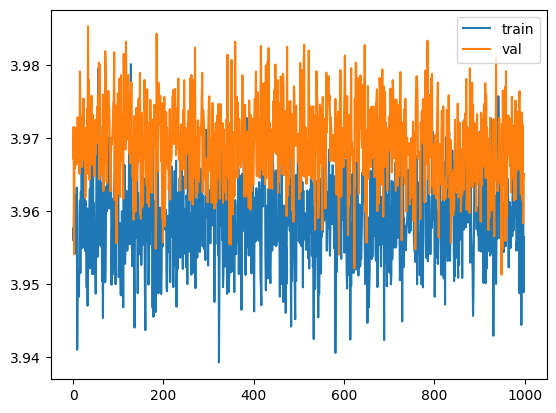

In [145]:
# Function to perform training
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=True):
    # Placeholder for storing losses
    losses = []

    # Start tracking time
    start_time = time.time()

    # Iterate through epochs
    for epoch in range(config['epochs']):
        # Zero out gradients
        optimizer.zero_grad()

        #print("epoch:",epoch)
        # Obtain batches for training
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

        # Forward pass through the model to calculate logits and loss
        logits, loss = model(xs, targets=ys)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # If a learning rate scheduler is provided, adjust the learning rate
        if scheduler:
            scheduler.step()

        # Log progress every specified interval
        if epoch % config['log_interval'] == 0:
            # Calculate batch time
            batch_time = time.time() - start_time

            # Evaluate loss on validation set
            x = evaluate_loss(model)

            # Store the validation loss
            losses += [x]

            # Print progress logs if specified
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")                

            # Reset the timer
            start_time = time.time()

            # Print learning rate if a scheduler is provided
            if scheduler:
                print("lr: ", scheduler.get_lr())

    # Print the final validation loss
    print("Validation loss: ", losses[-1]['val'])

    # Plot the training and validation loss curves
    return pd.DataFrame(losses).plot()

# Execute the training process
train(model, optimizer)

<img src="https://cdn-images-1.medium.com/max/17880/1*z1YNDzGegE2sg12SfkIZjw.png" alt="" width="50%">


The initial cross-entropy loss before training stands at 4.17, and after 1000 epochs, it reduces to 3.93. In this context, cross-entropy reflects the likelihood of selecting the incorrect word.

Our model incorporates a softmax layer on the logits, which transforms a vector of numbers into a probability distribution. Let’s use the built-in F.cross_entropy function, we need to directly pass in the [unnormalized logits](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html). Consequently, we will modify our model accordingly.

In [148]:
# Modified SimpleModel class without softmax layer
class SimpleModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        # Embedding layer to convert character indices to vectors (vocab size: 65)
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # Linear layers for modeling relationships between features
        # (to be updated with SwiGLU activation function as in LLaMA)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    # Forward pass function for the base model
    def forward(self, idx, targets=None):
        # Embedding layer converts character indices to vectors
        x = self.embedding(idx)

        # Linear layers for modeling relationships between features
        a = self.linear(x)

        # Apply softmax activation to obtain probability distribution
        # logits = F.softmax(a, dim=-1)
        logits = self.linear(x)

        # If targets are provided, calculate and return the cross-entropy loss
        if targets is not None:
            # Reshape logits and targets for cross-entropy calculation
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        # If targets are not provided, return the logits
        else:
            return logits

        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

Let’s recreate the updated SimpleModel and train it for 1000 epochs to observe any changes:

Model parameters: 33217
Epoch 0 | val loss 4.140 | Time 0.002 | ETA in seconds 1.937
Epoch 10 | val loss 3.532 | Time 0.015 | ETA in seconds 14.551
Epoch 20 | val loss 3.057 | Time 0.014 | ETA in seconds 14.462
Epoch 30 | val loss 2.804 | Time 0.014 | ETA in seconds 14.092
Epoch 40 | val loss 2.687 | Time 0.016 | ETA in seconds 15.524
Epoch 50 | val loss 2.648 | Time 0.015 | ETA in seconds 14.815
Epoch 60 | val loss 2.601 | Time 0.015 | ETA in seconds 14.751
Epoch 70 | val loss 2.565 | Time 0.015 | ETA in seconds 15.051
Epoch 80 | val loss 2.584 | Time 0.014 | ETA in seconds 13.918
Epoch 90 | val loss 2.550 | Time 0.014 | ETA in seconds 13.476
Epoch 100 | val loss 2.552 | Time 0.014 | ETA in seconds 13.392
Epoch 110 | val loss 2.538 | Time 0.014 | ETA in seconds 13.484
Epoch 120 | val loss 2.541 | Time 0.014 | ETA in seconds 14.031
Epoch 130 | val loss 2.540 | Time 0.014 | ETA in seconds 14.175
Epoch 140 | val loss 2.524 | Time 0.014 | ETA in seconds 13.985
Epoch 150 | val loss 2.516 |

<Axes: >

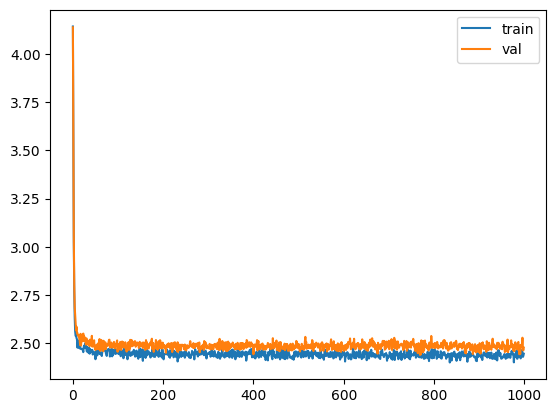

In [149]:
# Create the updated SimpleModel
model = SimpleModel(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model for 100 epochs
train(model, optimizer)

<img src="https://cdn-images-1.medium.com/max/21656/1*90UeocQghByPqaZ_g6dYEw.png" alt="" width="50%">


After reducing the loss to 2.51, let’s explore how our language model with approximately **33,000 parameters** generates text during inferencing. We’ll create a ‘generate’ function, which we’ll later use when replicating LLaMA:

In [150]:
# Generate function for text generation using the trained model
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # Call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

# Generate text using the trained model
generate(model)

['\nth ug mstoy\nastitalsus\nands ch',
 '\nto o me owefus gentanininthili',
 '\nwis ts corss ty cugren ins was',
 '\nag donsirse ofof arpliburesias',
 '\ntiapedeyourprgenthalanthof\nm t']

<img src="https://cdn-images-1.medium.com/max/43492/1*D1X9nqb8gPN5tXZJL2eAiQ.png" alt="" width="50%">


The generated text doesn’t look great with our basic model of around 33K parameters. However, now that we’ve laid the groundwork with this simple model, we’ll move on to constructing the LLaMA architecture in the next section.

## Replicating LLaMA Architecture

In the earlier part of the blog, we covered essential concepts, and now, we’ll integrate these concepts into our base model. LLaMA introduces three architectural modifications to the original Transformer:

 1. RMSNorm for pre-normalization

 2. Rotary embeddings

 3. SwiGLU activation function

We’ll incorporate each of these modifications one by one into our base model, iterating and building upon them.

### RMSNorm for pre-normalization:

We are defining an RMSNorm function with the following functionalities:

In [151]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()

        # Registering a learnable parameter 'scale' as a parameter of the module
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        Assumes shape is (batch, seq_len, d_model)
        """
        # Calculating the Frobenius norm, RMS = 1/sqrt(N) * Frobenius norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5

        # Normalizing the input tensor 'x' with respect to RMS
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)

        # Scaling the normalized tensor using the learnable parameter 'scale'
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

we define the RMSNorm class. During initialization, it registers a scale parameter. In the forward pass, it calculates the **Frobenius norm** of the input tensor and then normalizes the tensor. Finally, the tensor is scaled by the registered scale parameter. This function is designed for use in LLaMA to replace the LayerNorm operation.

Now it’s time to incorporate the first implementation concept of LLaMA, which is RMSNorm, into our simple NN model. Here’s the updated code:

In [152]:
# Define the SimpleModel_RMS with RMSNorm
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding layer to convert character indices to vectors
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # RMSNorm layer for pre-normalization
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # Linear layers for modeling relationships between features
        self.linear = nn.Sequential(
            # Rest of the code
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Embedding layer converts character indices to vectors
        x = self.embedding(idx)

        # RMSNorm pre-normalization
        x = self.rms(x)

        # Linear layers for modeling relationships between features
        logits = self.linear(x)

        # If targets are provided, calculate and return the cross-entropy loss
        if targets is not None:
            # Reshape logits and targets for cross-entropy calculation
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        # If targets are not provided, return the logits
        else:
            return logits

        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

Let’s execute the modified NN model with RMSNorm and observe the updated number of parameters in the model, along with the loss:

Model parameters: 35265
Epoch 0 | val loss 4.080 | Time 0.004 | ETA in seconds 4.029
Epoch 10 | val loss 3.486 | Time 0.018 | ETA in seconds 17.663
Epoch 20 | val loss 2.991 | Time 0.017 | ETA in seconds 16.835
Epoch 30 | val loss 2.797 | Time 0.017 | ETA in seconds 16.941
Epoch 40 | val loss 2.709 | Time 0.017 | ETA in seconds 17.357
Epoch 50 | val loss 2.580 | Time 0.017 | ETA in seconds 17.171
Epoch 60 | val loss 2.596 | Time 0.017 | ETA in seconds 17.074
Epoch 70 | val loss 2.540 | Time 0.017 | ETA in seconds 17.309
Epoch 80 | val loss 2.557 | Time 0.017 | ETA in seconds 17.020
Epoch 90 | val loss 2.555 | Time 0.017 | ETA in seconds 17.156
Epoch 100 | val loss 2.548 | Time 0.017 | ETA in seconds 17.203
Epoch 110 | val loss 2.514 | Time 0.017 | ETA in seconds 16.918
Epoch 120 | val loss 2.531 | Time 0.017 | ETA in seconds 17.132
Epoch 130 | val loss 2.543 | Time 0.018 | ETA in seconds 17.441
Epoch 140 | val loss 2.543 | Time 0.018 | ETA in seconds 17.508
Epoch 150 | val loss 2.505 |

<Axes: >

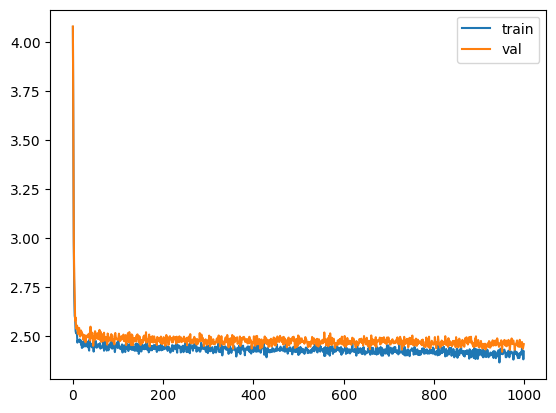

In [153]:
# Create an instance of SimpleModel_RMS
model = SimpleModel_RMS(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model
train(model, optimizer)

img src="https://cdn-images-1.medium.com/max/23800/1*f9hz23xc6xo9otvw5K00Nw.png" alt="" width="50%">


The validation loss experiences a small decrease, and the parameters of our updated LLM now total approximately 55,000.

### Rotary Embeddings:

Next, we will implement rotary positional embeddings. In RoPE, the authors suggest embedding the position of a token in a sequence by rotating the embedding, applying a different rotation at each position. Let’s create a function that mimics the actual paper implementation of RoPE:

In [163]:
def get_rotary_matrix(context_window, embedding_dim):
    # Initialize a tensor for the rotary matrix with zeros
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

    # Loop through each position in the context window
    for position in range(context_window):
        # Loop through each dimension in the embedding
        for i in range(embedding_dim // 2):
            # Calculate the rotation angle (theta) based on the position and embedding dimension
            theta = 10000. ** (-2. * (i - 1) / embedding_dim)
            # Calculate the rotated matrix elements using sine and cosine functions
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

we generate a rotary matrix based on the specified context window and embedding dimension, following the proposed RoPE implementation.

As you may be familiar with the architecture of transformers, which involves attention heads, we similarly need to create attention heads when replicating LLaMA. To start, let’s first create a single **masked attention head** using the get_rotary_matrix function we previously developed for rotary embeddings. **Additionally, each line is commented for clarity**:

In [166]:
##class RoPEAttentionHead(nn.Module):
class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Linear transformation for query
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for key
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for value
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Obtain rotary matrix for positional embeddings
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        # Generate rotational matrix for RoPE
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                # Calculate the rotation angle (theta) based on the position and embedding dimension
                theta = 10000. ** (-2. * (i - 1) / embedding_dim)
                # Calculate the rotated matrix elements using sine and cosine functions
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        # x: input tensor of shape (batch, sequence length, dimension)

        b, m, d = x.shape  # batch size, sequence length, dimension

        # Linear transformations for Q, K, and V
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        # Rotate Q and K using the RoPE matrix
        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

        # Perform scaled dot-product attention
        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            # Create a causal attention mask
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            # Calculate attention weights and add causal mask
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights

        return activations

Now that we have a single masked attention head that returns attention weights, the next step is to create a multi-Head attention mechanism.

In [167]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Create a list of RoPEMaskedAttentionHead instances as attention heads
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])  # Linear layer after concatenating heads
        self.dropout = nn.Dropout(.1)  # Dropout layer

    def forward(self, x):
        # x: input tensor of shape (batch, sequence length, dimension)

        # Process each attention head and concatenate the results
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)

        # Apply linear transformation to the concatenated output
        x = self.linear(x)

        # Apply dropout
        x = self.dropout(x)
        return x

The original paper used 32 heads for their smaller 7b LLM variation, but due to constraints, we’ll use 8 heads for our approach.

In [168]:
# Update the master configuration with the number of attention heads
MASTER_CONFIG.update({
    'n_heads': 8,
})


Now that we’ve implemented Rotational Embedding and Multi-head Attention, let’s re-write our RMSNorm neural network model with the updated code. We’ll test its performance, compute the loss, and check the number of parameters. We’ll refer to this updated model as **“RopeModel”**

In [169]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding layer for input tokens
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # RMSNorm layer for pre-normalization
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # RoPEMaskedMultiheadAttention layer
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        # Linear layer followed by ReLU activation
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        # Final linear layer for prediction
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # idx: input indices
        x = self.embedding(idx)

        # One block of attention
        x = self.rms(x)  # RMS pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x)  # RMS pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits


Let’s execute the modified NN model with RMSNorm, Rotational Embeddings and Masked Multi Head Attentions to observe the updated number of parameters in the model, along with the loss:

model params: 559681
Epoch 0 | val loss 4.124 | Time 0.026 | ETA in seconds 26.358
Epoch 10 | val loss 2.915 | Time 0.192 | ETA in seconds 191.658
Epoch 20 | val loss 2.714 | Time 0.186 | ETA in seconds 185.744
Epoch 30 | val loss 2.618 | Time 0.190 | ETA in seconds 189.771
Epoch 40 | val loss 2.562 | Time 0.195 | ETA in seconds 194.303
Epoch 50 | val loss 2.546 | Time 0.193 | ETA in seconds 191.749
Epoch 60 | val loss 2.520 | Time 0.195 | ETA in seconds 194.166
Epoch 70 | val loss 2.471 | Time 0.197 | ETA in seconds 195.668
Epoch 80 | val loss 2.402 | Time 0.193 | ETA in seconds 191.919
Epoch 90 | val loss 2.447 | Time 0.179 | ETA in seconds 177.002
Epoch 100 | val loss 2.440 | Time 0.196 | ETA in seconds 193.870
Epoch 110 | val loss 2.382 | Time 0.183 | ETA in seconds 180.627
Epoch 120 | val loss 2.358 | Time 0.181 | ETA in seconds 178.988
Epoch 130 | val loss 2.391 | Time 0.180 | ETA in seconds 177.354
Epoch 140 | val loss 2.366 | Time 0.177 | ETA in seconds 174.450
Epoch 150 | val 

<Axes: >

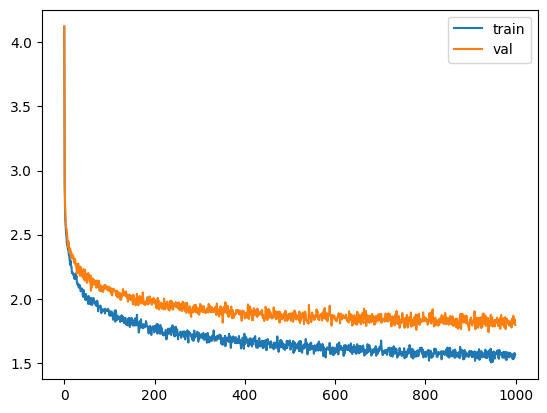

In [170]:
# Create an instance of RopeModel (RMSNorm, RoPE, Multi-Head)
model = RopeModel(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model
train(model, optimizer)

<img src="https://cdn-images-1.medium.com/max/20664/1*6MiNSfJf8x8xZqWkiy51Tg.png" alt="" width="50%">


The validation loss experiences a small decrease again, and the parameters of our updated LLM now total approximately 55,000.

Let’s train the model for more epochs to see if the loss of our recreated LLaMA LLM continues to decrease or not.

Epoch 0 | val loss 1.795 | Time 0.024 | ETA in seconds 11.761
Epoch 10 | val loss 1.823 | Time 0.177 | ETA in seconds 88.211
Epoch 20 | val loss 1.857 | Time 0.190 | ETA in seconds 94.808
Epoch 30 | val loss 1.813 | Time 0.190 | ETA in seconds 94.200
Epoch 40 | val loss 1.827 | Time 0.189 | ETA in seconds 93.517
Epoch 50 | val loss 1.777 | Time 0.192 | ETA in seconds 95.086
Epoch 60 | val loss 1.811 | Time 0.188 | ETA in seconds 93.089
Epoch 70 | val loss 1.805 | Time 0.195 | ETA in seconds 96.250
Epoch 80 | val loss 1.810 | Time 0.186 | ETA in seconds 91.660
Epoch 90 | val loss 1.817 | Time 0.182 | ETA in seconds 89.596
Epoch 100 | val loss 1.829 | Time 0.188 | ETA in seconds 92.212
Epoch 110 | val loss 1.788 | Time 0.183 | ETA in seconds 89.583
Epoch 120 | val loss 1.809 | Time 0.179 | ETA in seconds 87.202
Epoch 130 | val loss 1.814 | Time 0.173 | ETA in seconds 84.067
Epoch 140 | val loss 1.786 | Time 0.177 | ETA in seconds 85.866
Epoch 150 | val loss 1.795 | Time 0.170 | ETA in se

<Axes: >

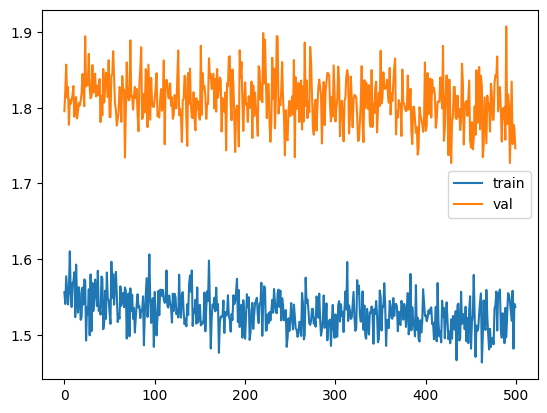

In [171]:
# Updating training configuration with more epochs and a logging interval
MASTER_CONFIG.update({
    "epochs": 5000,
    "log_interval": 10,
})

# Training the model with the updated configuration
train(model, optimizer)

<img src="https://cdn-images-1.medium.com/max/20664/1*JxlI2_wH8OHDrizFoJF6Kw.png" alt="" width="50%">


The validation loss continues to decrease, suggesting that training for more epochs could lead to further loss reduction, though not significantly.

### SwiGLU activation function:

As mentioned before, the creators of LLaMA use SwiGLU instead of ReLU, so we’ll be implementing SwiGLU equation in our code.

![[https://arxiv.org/pdf/2002.05202v1.pdf](https://arxiv.org/pdf/2002.05202v1.pdf)](https://cdn-images-1.medium.com/max/27072/1*db6BeMw78FH_ZkVEGIyVPA.png)

In [177]:
class SwiGLU(nn.Module):
    """ Paper Link -> https://arxiv.org/pdf/2002.05202v1.pdf """
    def __init__(self, size):
        super().__init__()
        #self.config = config  # Configuration information
        self.linear_gate = nn.Linear(size, size)  # Linear transformation for the gating mechanism
        self.linear = nn.Linear(size, size)  # Linear transformation for the main branch
        self.beta = torch.randn(1, requires_grad=True)  # Random initialization of the beta parameter

        # Using nn.Parameter for beta to ensure it's recognized as a learnable parameter
        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        # Swish-Gated Linear Unit computation
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)  # Element-wise multiplication of the gate and main branch
        return out

After implementing the SwiGLU equation in python, we need to integrate it into our modified LLaMA language model (**RopeModel**).

In [178]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding layer for input tokens
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # RMSNorm layer for pre-normalization
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # Multi-head attention layer with RoPE (Rotary Positional Embeddings)
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        # Linear layer followed by SwiGLU activation
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),  # Adding SwiGLU activation
        )

        # Output linear layer
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        # Printing total model parameters
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # One block of attention
        x = self.rms(x)  # RMS pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x)  # RMS pre-normalization
        x = x + self.linear(x)  # Applying SwiGLU activation

        logits = self.last_linear(x)

        if targets is not None:
            # Calculate cross-entropy loss if targets are provided
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

Let’s execute the modified NN model with RMSNorm, Rotational Embeddings, Masked Multi Head Attentions and SwiGLU to observe the updated number of parameters in the model, along with the loss:

model params: 592706
Epoch 0 | val loss 4.140 | Time 0.024 | ETA in seconds 12.153
Epoch 10 | val loss 2.928 | Time 0.208 | ETA in seconds 103.596
Epoch 20 | val loss 2.718 | Time 0.206 | ETA in seconds 102.777
Epoch 30 | val loss 2.630 | Time 0.206 | ETA in seconds 102.557
Epoch 40 | val loss 2.582 | Time 0.208 | ETA in seconds 103.332
Epoch 50 | val loss 2.544 | Time 0.205 | ETA in seconds 101.283
Epoch 60 | val loss 2.498 | Time 0.196 | ETA in seconds 97.069
Epoch 70 | val loss 2.469 | Time 0.199 | ETA in seconds 97.890
Epoch 80 | val loss 2.479 | Time 0.187 | ETA in seconds 92.164
Epoch 90 | val loss 2.431 | Time 0.198 | ETA in seconds 97.204
Epoch 100 | val loss 2.405 | Time 0.191 | ETA in seconds 93.662
Epoch 110 | val loss 2.369 | Time 0.190 | ETA in seconds 92.905
Epoch 120 | val loss 2.372 | Time 0.192 | ETA in seconds 93.537
Epoch 130 | val loss 2.348 | Time 0.182 | ETA in seconds 88.550
Epoch 140 | val loss 2.353 | Time 0.196 | ETA in seconds 95.387
Epoch 150 | val loss 2.29

<Axes: >

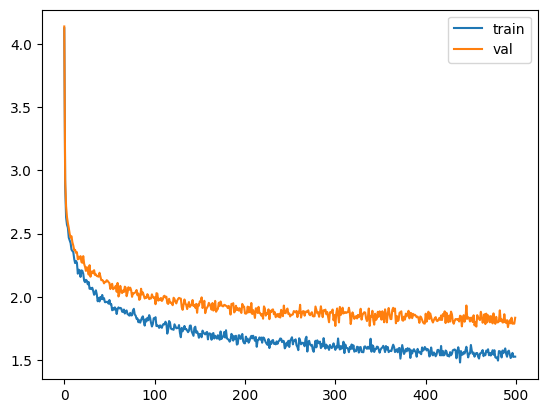

In [179]:
# Create an instance of RopeModel (RMSNorm, RoPE, Multi-Head, SwiGLU)
model = RopeModel(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model
train(model, optimizer)

<img src="https://cdn-images-1.medium.com/max/23288/1*P3Z15lV1LNLZdsEpTd2mSA.png" alt="" width="50%">

nce again the validation loss experiences a small decrease, and the parameters of our updated LLM now total approximately 60,000.

So far, we have successfully implemented the key components of the paper, namely RMSNorm, RoPE, and SwiGLU. We observed that these implementations led to a minimal decrease in the loss.

Now we will add layers to our LLaMA to examine its impact on the loss. The original paper used 32 layers for the 7b version, but we will use only 4 layers. Let’s adjust our model settings accordingly.

In [180]:
# Update model configurations for the number of layers
MASTER_CONFIG.update({
    'n_layers': 4,  # Set the number of layers to 4
})

Let’s start by creating a single layer to understand its impact.

In [181]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # RMSNorm layer
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # RoPE Masked Multihead Attention layer
        self.attention = RoPEMaskedMultiheadAttention(config)

        # Feedforward layer with SwiGLU activation
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        # one block of attention
        x = self.rms(x) # RMS pre-normalization
        x = x + self.attention(x)  # residual connection

        x = self.rms(x) # RMS pre-normalization
        x = x + self.feedforward(x)  # residual connection
        return x

Create an instance of the LlamaBlock class and applies it to a random tensor.

In [182]:
# Create an instance of the LlamaBlock class with the provided configuration
block = LlamaBlock(MASTER_CONFIG)

# Generate a random tensor with the specified batch size, context window, and model dimension
random_input = torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model'])

# Apply the LlamaBlock to the random input tensor
output = block(random_input)

Having successfully created a single layer, we can now use it to construct multiple layers. Additionally, we will rename our model class from **“ropemodel”** to **“Llama”** as we have replicated every component of the LLaMA language model.

In [185]:
import collections

try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict
    
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Embedding layer for token representations
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        # Sequential block of LlamaBlocks based on the specified number of layers
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )
        # Feedforward network (FFN) for final output
        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print total number of parameters in the model
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Input token indices are passed through the embedding layer
        x = self.embeddings(idx)
        # Process the input through the LlamaBlocks
        x = self.llama_blocks(x)
        # Pass the processed input through the final FFN for output logits
        logits = self.ffn(x)

        # If targets are not provided, return only the logits
        if targets is None:
            return logits
        # If targets are provided, compute and return the cross-entropy loss
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

Let’s execute the modified LLaMA model with RMSNorm, Rotational Embeddings, Masked Multi Head Attentions, SwiGLU and N_layers to observe the updated number of parameters in the model, along with the loss:

model params: 2370246
Epoch 0 | val loss 4.139 | Time 0.114 | ETA in seconds 57.020
Epoch 10 | val loss 3.077 | Time 0.851 | ETA in seconds 424.519
Epoch 20 | val loss 2.943 | Time 0.731 | ETA in seconds 364.147
Epoch 30 | val loss 2.863 | Time 0.726 | ETA in seconds 360.856
Epoch 40 | val loss 2.743 | Time 0.721 | ETA in seconds 357.422
Epoch 50 | val loss 2.663 | Time 0.720 | ETA in seconds 356.617
Epoch 60 | val loss 2.558 | Time 0.722 | ETA in seconds 356.514
Epoch 70 | val loss 2.519 | Time 0.723 | ETA in seconds 356.368
Epoch 80 | val loss 2.488 | Time 0.726 | ETA in seconds 357.367
Epoch 90 | val loss 2.431 | Time 0.727 | ETA in seconds 356.797
Epoch 100 | val loss 2.402 | Time 0.735 | ETA in seconds 360.373
Epoch 110 | val loss 2.433 | Time 0.726 | ETA in seconds 355.169
Epoch 120 | val loss 2.376 | Time 0.731 | ETA in seconds 356.894
Epoch 130 | val loss 2.363 | Time 0.724 | ETA in seconds 352.638
Epoch 140 | val loss 2.317 | Time 0.741 | ETA in seconds 359.928
Epoch 150 | val

<Axes: >

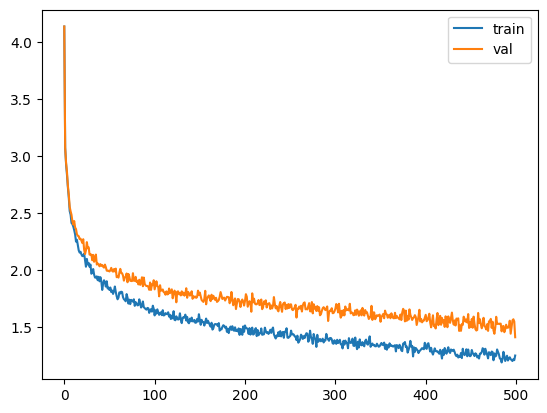

In [186]:
# Create an instance of RopeModel (RMSNorm, RoPE, Multi-Head, SwiGLU, N_layers)
llama = Llama(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = llama(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(llama.parameters())

# Train the model
train(llama, optimizer)

<img src="https://cdn-images-1.medium.com/max/26104/1*hNJ7JxurShESQj6E5fsNrg.png" alt="" width="50%">


While there’s a possibility of overfitting, it’s crucial to explore whether extending the number of epochs leads to a further reduction in loss. Additionally, note that our current LLM has over 2 million parameters.

Let’s train it for higher number of epochs.

Epoch 0 | val loss 1.537 | Time 0.084 | ETA in seconds 84.432
Epoch 10 | val loss 1.524 | Time 0.733 | ETA in seconds 732.225
Epoch 20 | val loss 1.517 | Time 0.743 | ETA in seconds 741.939
Epoch 30 | val loss 1.537 | Time 0.748 | ETA in seconds 745.632
Epoch 40 | val loss 1.504 | Time 0.720 | ETA in seconds 716.969
Epoch 50 | val loss 1.539 | Time 0.744 | ETA in seconds 739.873
Epoch 60 | val loss 1.497 | Time 0.773 | ETA in seconds 767.916
Epoch 70 | val loss 1.517 | Time 0.769 | ETA in seconds 763.380
Epoch 80 | val loss 1.515 | Time 0.733 | ETA in seconds 727.515
Epoch 90 | val loss 1.463 | Time 0.738 | ETA in seconds 731.515
Epoch 100 | val loss 1.495 | Time 0.745 | ETA in seconds 737.544
Epoch 110 | val loss 1.543 | Time 0.750 | ETA in seconds 741.794
Epoch 120 | val loss 1.486 | Time 0.730 | ETA in seconds 721.197
Epoch 130 | val loss 1.532 | Time 0.737 | ETA in seconds 727.306
Epoch 140 | val loss 1.443 | Time 0.732 | ETA in seconds 721.432
Epoch 150 | val loss 1.511 | Time 0.7

<Axes: >

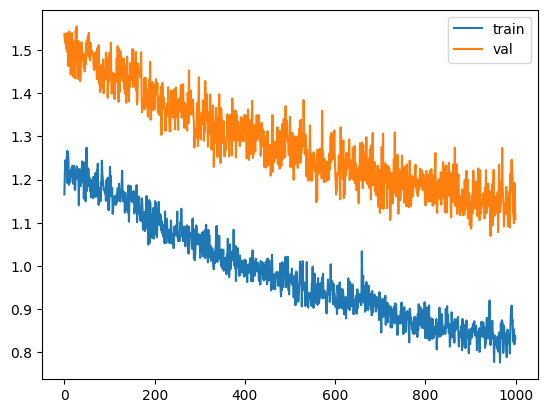

In [187]:
# Update the number of epochs in the configuration
MASTER_CONFIG.update({
    'epochs': 10000,
})
# Train the LLaMA model for the specified number of epochs
train(llama, optimizer, scheduler=None, config=MASTER_CONFIG)

<img src="https://cdn-images-1.medium.com/max/26104/1*qKCUQza7EbFPYIO0IJd6ew.png" alt="" width="50%">


The loss here is 1.08, we can achieve even more lower loss without encountering significant overfitting. This suggests the model is performing well.

Let’s train the model once more, this time incorporating a scheduler

Epoch 0 | val loss 1.151 | Time 0.076 | ETA in seconds 76.051
Epoch 10 | val loss 1.140 | Time 0.726 | ETA in seconds 724.849
Epoch 20 | val loss 1.127 | Time 0.723 | ETA in seconds 721.279
Epoch 30 | val loss 1.148 | Time 0.726 | ETA in seconds 724.066
Epoch 40 | val loss 1.190 | Time 0.738 | ETA in seconds 734.800
Epoch 50 | val loss 1.133 | Time 0.741 | ETA in seconds 736.835
Epoch 60 | val loss 1.100 | Time 0.743 | ETA in seconds 738.971
Epoch 70 | val loss 1.223 | Time 0.748 | ETA in seconds 742.859
Epoch 80 | val loss 1.122 | Time 0.744 | ETA in seconds 737.797
Epoch 90 | val loss 1.173 | Time 0.736 | ETA in seconds 729.225
Epoch 100 | val loss 1.202 | Time 0.725 | ETA in seconds 717.438
Epoch 110 | val loss 1.166 | Time 0.723 | ETA in seconds 715.298
Epoch 120 | val loss 1.270 | Time 0.737 | ETA in seconds 727.752
Epoch 130 | val loss 1.127 | Time 0.728 | ETA in seconds 719.006
Epoch 140 | val loss 1.126 | Time 0.747 | ETA in seconds 736.677
Epoch 150 | val loss 1.193 | Time 0.7

<Axes: >

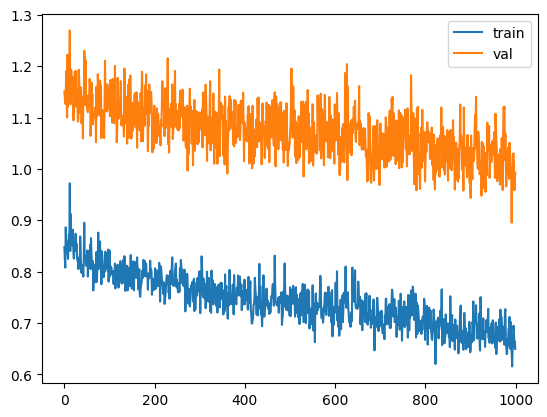

In [188]:
# Training the model again, scheduler for better optimization.
train(llama, optimizer, config=MASTER_CONFIG)

<img src="https://cdn-images-1.medium.com/max/26104/1*ov1mEWSeLXz8NACkErQZbA.png" alt="" width="50%">


Up until now, we’ve successfully implemented a scaled-down version of the LLaMA architecture on our custom dataset. Now, let’s examine the generated output from our 2 million-parameter Language Model.

In [189]:
# Generate text using the trained LLM (llama) with a maximum of 500 tokens
generated_text = generate(llama, MASTER_CONFIG, 500)[0]
print(generated_text)


e-cacanters compling to confrom they
smorional otherr genius perspect undures it a knowledge by of apply realized the simulating minute and cun pare hidden genius resitonestr to
scurediods or idential terre into to caistand ongentively attorally often
role curiosity as ensurate to
desiderify it
allows a
singliftly are ourselfs
To in alignistament ardities it
purtautionaly to
preader and
routiness and
comprecience through grow or another
comborouting commine focus yourally and musically and prior


<img src="https://cdn-images-1.medium.com/max/31844/1*NRnC0gQnbdCFkYaROiVbtw.png" alt="" width="50%">


Even though some generated words may not be perfect English, our LLM with just 2 million parameters has shown a basic understanding of the English language.

Now, let’s see how well our model performs on the test set.

In [194]:
# Get batches from the test set
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Pass the test data through the LLaMA model
logits, loss = llama(xs, ys)

# Print the loss on the test set
print(loss)

tensor(1.1172, grad_fn=<NllLossBackward0>)


The computed loss on the test set is approximately 1.236.

A simple way to check for changes in the generated output is to run training for a large number of epochs and observe the results.

## Experimenting with hyperparameters

Hyperparameter tuning is a crucial step in training neural networks. In the original Llama paper, the authors utilized the Cosine Annealing learning schedule. However, in our experimentation, it didn’t perform well. Here’s an example of experimenting with hyperparameters using a different learning schedule:

model params: 2370246
Epoch 0 | val loss 4.168 | Time 0.073 | ETA in seconds 7.346
lr:  [0.0009999457184159408]


/miniconda/envs/moe311/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:809: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 10 | val loss 4.166 | Time 0.661 | ETA in seconds 65.404
lr:  [0.0009961510274583004]
Epoch 20 | val loss 4.166 | Time 0.641 | ETA in seconds 62.774
lr:  [0.0009869757772816292]
Epoch 30 | val loss 4.168 | Time 0.638 | ETA in seconds 61.906
lr:  [0.0009725204933511963]
Epoch 40 | val loss 4.166 | Time 0.617 | ETA in seconds 59.263
lr:  [0.0009529435502760634]
Epoch 50 | val loss 4.166 | Time 0.629 | ETA in seconds 59.798
lr:  [0.0009284594366176498]
Epoch 60 | val loss 4.166 | Time 0.642 | ETA in seconds 60.374
lr:  [0.0008993364049014041]
Epoch 70 | val loss 4.167 | Time 0.618 | ETA in seconds 57.452
lr:  [0.0008658935325782156]
Epoch 80 | val loss 4.167 | Time 0.644 | ETA in seconds 59.249
lr:  [0.0008284972261358946]
Epoch 90 | val loss 4.167 | Time 0.648 | ETA in seconds 58.949
lr:  [0.0007875572066618724]
Epoch 100 | val loss 4.167 | Time 0.655 | ETA in seconds 58.980
lr:  [0.0007435220208394261]
Epoch 110 | val loss 4.167 | Time 0.645 | ETA in seconds 57.408
lr:  [0.0006968

<Axes: >

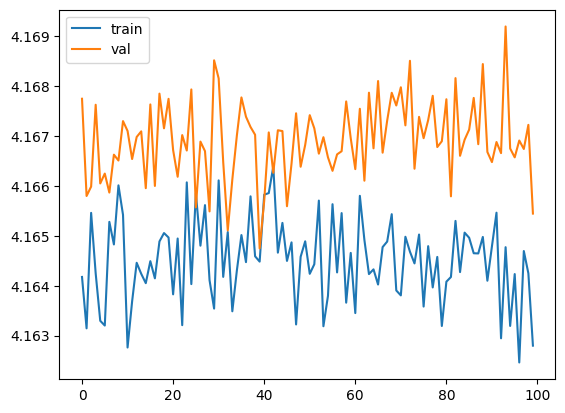

In [191]:
# Update configuration
MASTER_CONFIG.update({
    "epochs": 1000
})

# Create Llama model with Cosine Annealing learning schedule
llama_with_cosine = Llama(MASTER_CONFIG)

# Define Adam optimizer with specific hyperparameters
llama_optimizer = torch.optim.Adam(
    llama.parameters(),
    betas=(.9, .95),
    weight_decay=.1,
    eps=1e-9,
    lr=1e-3
)

# Define Cosine Annealing learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)

# Train the Llama model with the specified optimizer and scheduler
train(llama_with_cosine, llama_optimizer, scheduler=scheduler)

## Saving Your Language Model (LLM)

You can save your entire LLM or just the parameters using the following:

In [196]:
# Save the entire model
torch.save(llama, 'llama_model.pth')

# If you want to save only the model parameters
torch.save(llama.state_dict(), 'llama_model_params.pth')


To save your PyTorch model for Hugging Face’s Transformers library, you can use the save_pretrained method. Here's an example:


In [198]:
from transformers import GPT2LMHeadModel, GPT2Config

# Assuming Llama is your PyTorch model
llama_config = GPT2Config.from_dict(MASTER_CONFIG)
llama_transformers = GPT2LMHeadModel(config=llama_config)
#llama_transformers.load_state_dict(llama.state_dict())
llama_transformers.load_state_dict(llama.state_dict())

# Specify the directory where you want to save the model
output_dir = "llama_model_transformers"

# Save the model and configuration
llama_transformers.save_pretrained(output_dir)

RuntimeError: Error(s) in loading state_dict for GPT2LMHeadModel:
	Missing key(s) in state_dict: "transformer.wte.weight", "transformer.wpe.weight", "transformer.h.0.ln_1.weight", "transformer.h.0.ln_1.bias", "transformer.h.0.attn.c_attn.weight", "transformer.h.0.attn.c_attn.bias", "transformer.h.0.attn.c_proj.weight", "transformer.h.0.attn.c_proj.bias", "transformer.h.0.ln_2.weight", "transformer.h.0.ln_2.bias", "transformer.h.0.mlp.c_fc.weight", "transformer.h.0.mlp.c_fc.bias", "transformer.h.0.mlp.c_proj.weight", "transformer.h.0.mlp.c_proj.bias", "transformer.h.1.ln_1.weight", "transformer.h.1.ln_1.bias", "transformer.h.1.attn.c_attn.weight", "transformer.h.1.attn.c_attn.bias", "transformer.h.1.attn.c_proj.weight", "transformer.h.1.attn.c_proj.bias", "transformer.h.1.ln_2.weight", "transformer.h.1.ln_2.bias", "transformer.h.1.mlp.c_fc.weight", "transformer.h.1.mlp.c_fc.bias", "transformer.h.1.mlp.c_proj.weight", "transformer.h.1.mlp.c_proj.bias", "transformer.h.2.ln_1.weight", "transformer.h.2.ln_1.bias", "transformer.h.2.attn.c_attn.weight", "transformer.h.2.attn.c_attn.bias", "transformer.h.2.attn.c_proj.weight", "transformer.h.2.attn.c_proj.bias", "transformer.h.2.ln_2.weight", "transformer.h.2.ln_2.bias", "transformer.h.2.mlp.c_fc.weight", "transformer.h.2.mlp.c_fc.bias", "transformer.h.2.mlp.c_proj.weight", "transformer.h.2.mlp.c_proj.bias", "transformer.h.3.ln_1.weight", "transformer.h.3.ln_1.bias", "transformer.h.3.attn.c_attn.weight", "transformer.h.3.attn.c_attn.bias", "transformer.h.3.attn.c_proj.weight", "transformer.h.3.attn.c_proj.bias", "transformer.h.3.ln_2.weight", "transformer.h.3.ln_2.bias", "transformer.h.3.mlp.c_fc.weight", "transformer.h.3.mlp.c_fc.bias", "transformer.h.3.mlp.c_proj.weight", "transformer.h.3.mlp.c_proj.bias", "transformer.h.4.ln_1.weight", "transformer.h.4.ln_1.bias", "transformer.h.4.attn.c_attn.weight", "transformer.h.4.attn.c_attn.bias", "transformer.h.4.attn.c_proj.weight", "transformer.h.4.attn.c_proj.bias", "transformer.h.4.ln_2.weight", "transformer.h.4.ln_2.bias", "transformer.h.4.mlp.c_fc.weight", "transformer.h.4.mlp.c_fc.bias", "transformer.h.4.mlp.c_proj.weight", "transformer.h.4.mlp.c_proj.bias", "transformer.h.5.ln_1.weight", "transformer.h.5.ln_1.bias", "transformer.h.5.attn.c_attn.weight", "transformer.h.5.attn.c_attn.bias", "transformer.h.5.attn.c_proj.weight", "transformer.h.5.attn.c_proj.bias", "transformer.h.5.ln_2.weight", "transformer.h.5.ln_2.bias", "transformer.h.5.mlp.c_fc.weight", "transformer.h.5.mlp.c_fc.bias", "transformer.h.5.mlp.c_proj.weight", "transformer.h.5.mlp.c_proj.bias", "transformer.h.6.ln_1.weight", "transformer.h.6.ln_1.bias", "transformer.h.6.attn.c_attn.weight", "transformer.h.6.attn.c_attn.bias", "transformer.h.6.attn.c_proj.weight", "transformer.h.6.attn.c_proj.bias", "transformer.h.6.ln_2.weight", "transformer.h.6.ln_2.bias", "transformer.h.6.mlp.c_fc.weight", "transformer.h.6.mlp.c_fc.bias", "transformer.h.6.mlp.c_proj.weight", "transformer.h.6.mlp.c_proj.bias", "transformer.h.7.ln_1.weight", "transformer.h.7.ln_1.bias", "transformer.h.7.attn.c_attn.weight", "transformer.h.7.attn.c_attn.bias", "transformer.h.7.attn.c_proj.weight", "transformer.h.7.attn.c_proj.bias", "transformer.h.7.ln_2.weight", "transformer.h.7.ln_2.bias", "transformer.h.7.mlp.c_fc.weight", "transformer.h.7.mlp.c_fc.bias", "transformer.h.7.mlp.c_proj.weight", "transformer.h.7.mlp.c_proj.bias", "transformer.h.8.ln_1.weight", "transformer.h.8.ln_1.bias", "transformer.h.8.attn.c_attn.weight", "transformer.h.8.attn.c_attn.bias", "transformer.h.8.attn.c_proj.weight", "transformer.h.8.attn.c_proj.bias", "transformer.h.8.ln_2.weight", "transformer.h.8.ln_2.bias", "transformer.h.8.mlp.c_fc.weight", "transformer.h.8.mlp.c_fc.bias", "transformer.h.8.mlp.c_proj.weight", "transformer.h.8.mlp.c_proj.bias", "transformer.h.9.ln_1.weight", "transformer.h.9.ln_1.bias", "transformer.h.9.attn.c_attn.weight", "transformer.h.9.attn.c_attn.bias", "transformer.h.9.attn.c_proj.weight", "transformer.h.9.attn.c_proj.bias", "transformer.h.9.ln_2.weight", "transformer.h.9.ln_2.bias", "transformer.h.9.mlp.c_fc.weight", "transformer.h.9.mlp.c_fc.bias", "transformer.h.9.mlp.c_proj.weight", "transformer.h.9.mlp.c_proj.bias", "transformer.h.10.ln_1.weight", "transformer.h.10.ln_1.bias", "transformer.h.10.attn.c_attn.weight", "transformer.h.10.attn.c_attn.bias", "transformer.h.10.attn.c_proj.weight", "transformer.h.10.attn.c_proj.bias", "transformer.h.10.ln_2.weight", "transformer.h.10.ln_2.bias", "transformer.h.10.mlp.c_fc.weight", "transformer.h.10.mlp.c_fc.bias", "transformer.h.10.mlp.c_proj.weight", "transformer.h.10.mlp.c_proj.bias", "transformer.h.11.ln_1.weight", "transformer.h.11.ln_1.bias", "transformer.h.11.attn.c_attn.weight", "transformer.h.11.attn.c_attn.bias", "transformer.h.11.attn.c_proj.weight", "transformer.h.11.attn.c_proj.bias", "transformer.h.11.ln_2.weight", "transformer.h.11.ln_2.bias", "transformer.h.11.mlp.c_fc.weight", "transformer.h.11.mlp.c_fc.bias", "transformer.h.11.mlp.c_proj.weight", "transformer.h.11.mlp.c_proj.bias", "transformer.ln_f.weight", "transformer.ln_f.bias", "lm_head.weight". 
	Unexpected key(s) in state_dict: "embeddings.weight", "llama_blocks.llama_0.rms.scale", "llama_blocks.llama_0.attention.heads.0.w_q.weight", "llama_blocks.llama_0.attention.heads.0.w_k.weight", "llama_blocks.llama_0.attention.heads.0.w_v.weight", "llama_blocks.llama_0.attention.heads.1.w_q.weight", "llama_blocks.llama_0.attention.heads.1.w_k.weight", "llama_blocks.llama_0.attention.heads.1.w_v.weight", "llama_blocks.llama_0.attention.heads.2.w_q.weight", "llama_blocks.llama_0.attention.heads.2.w_k.weight", "llama_blocks.llama_0.attention.heads.2.w_v.weight", "llama_blocks.llama_0.attention.heads.3.w_q.weight", "llama_blocks.llama_0.attention.heads.3.w_k.weight", "llama_blocks.llama_0.attention.heads.3.w_v.weight", "llama_blocks.llama_0.attention.heads.4.w_q.weight", "llama_blocks.llama_0.attention.heads.4.w_k.weight", "llama_blocks.llama_0.attention.heads.4.w_v.weight", "llama_blocks.llama_0.attention.heads.5.w_q.weight", "llama_blocks.llama_0.attention.heads.5.w_k.weight", "llama_blocks.llama_0.attention.heads.5.w_v.weight", "llama_blocks.llama_0.attention.heads.6.w_q.weight", "llama_blocks.llama_0.attention.heads.6.w_k.weight", "llama_blocks.llama_0.attention.heads.6.w_v.weight", "llama_blocks.llama_0.attention.heads.7.w_q.weight", "llama_blocks.llama_0.attention.heads.7.w_k.weight", "llama_blocks.llama_0.attention.heads.7.w_v.weight", "llama_blocks.llama_0.attention.linear.weight", "llama_blocks.llama_0.attention.linear.bias", "llama_blocks.llama_0.feedforward.0.weight", "llama_blocks.llama_0.feedforward.0.bias", "llama_blocks.llama_0.feedforward.1.beta", "llama_blocks.llama_0.feedforward.1.linear_gate.weight", "llama_blocks.llama_0.feedforward.1.linear_gate.bias", "llama_blocks.llama_0.feedforward.1.linear.weight", "llama_blocks.llama_0.feedforward.1.linear.bias", "llama_blocks.llama_1.rms.scale", "llama_blocks.llama_1.attention.heads.0.w_q.weight", "llama_blocks.llama_1.attention.heads.0.w_k.weight", "llama_blocks.llama_1.attention.heads.0.w_v.weight", "llama_blocks.llama_1.attention.heads.1.w_q.weight", "llama_blocks.llama_1.attention.heads.1.w_k.weight", "llama_blocks.llama_1.attention.heads.1.w_v.weight", "llama_blocks.llama_1.attention.heads.2.w_q.weight", "llama_blocks.llama_1.attention.heads.2.w_k.weight", "llama_blocks.llama_1.attention.heads.2.w_v.weight", "llama_blocks.llama_1.attention.heads.3.w_q.weight", "llama_blocks.llama_1.attention.heads.3.w_k.weight", "llama_blocks.llama_1.attention.heads.3.w_v.weight", "llama_blocks.llama_1.attention.heads.4.w_q.weight", "llama_blocks.llama_1.attention.heads.4.w_k.weight", "llama_blocks.llama_1.attention.heads.4.w_v.weight", "llama_blocks.llama_1.attention.heads.5.w_q.weight", "llama_blocks.llama_1.attention.heads.5.w_k.weight", "llama_blocks.llama_1.attention.heads.5.w_v.weight", "llama_blocks.llama_1.attention.heads.6.w_q.weight", "llama_blocks.llama_1.attention.heads.6.w_k.weight", "llama_blocks.llama_1.attention.heads.6.w_v.weight", "llama_blocks.llama_1.attention.heads.7.w_q.weight", "llama_blocks.llama_1.attention.heads.7.w_k.weight", "llama_blocks.llama_1.attention.heads.7.w_v.weight", "llama_blocks.llama_1.attention.linear.weight", "llama_blocks.llama_1.attention.linear.bias", "llama_blocks.llama_1.feedforward.0.weight", "llama_blocks.llama_1.feedforward.0.bias", "llama_blocks.llama_1.feedforward.1.beta", "llama_blocks.llama_1.feedforward.1.linear_gate.weight", "llama_blocks.llama_1.feedforward.1.linear_gate.bias", "llama_blocks.llama_1.feedforward.1.linear.weight", "llama_blocks.llama_1.feedforward.1.linear.bias", "llama_blocks.llama_2.rms.scale", "llama_blocks.llama_2.attention.heads.0.w_q.weight", "llama_blocks.llama_2.attention.heads.0.w_k.weight", "llama_blocks.llama_2.attention.heads.0.w_v.weight", "llama_blocks.llama_2.attention.heads.1.w_q.weight", "llama_blocks.llama_2.attention.heads.1.w_k.weight", "llama_blocks.llama_2.attention.heads.1.w_v.weight", "llama_blocks.llama_2.attention.heads.2.w_q.weight", "llama_blocks.llama_2.attention.heads.2.w_k.weight", "llama_blocks.llama_2.attention.heads.2.w_v.weight", "llama_blocks.llama_2.attention.heads.3.w_q.weight", "llama_blocks.llama_2.attention.heads.3.w_k.weight", "llama_blocks.llama_2.attention.heads.3.w_v.weight", "llama_blocks.llama_2.attention.heads.4.w_q.weight", "llama_blocks.llama_2.attention.heads.4.w_k.weight", "llama_blocks.llama_2.attention.heads.4.w_v.weight", "llama_blocks.llama_2.attention.heads.5.w_q.weight", "llama_blocks.llama_2.attention.heads.5.w_k.weight", "llama_blocks.llama_2.attention.heads.5.w_v.weight", "llama_blocks.llama_2.attention.heads.6.w_q.weight", "llama_blocks.llama_2.attention.heads.6.w_k.weight", "llama_blocks.llama_2.attention.heads.6.w_v.weight", "llama_blocks.llama_2.attention.heads.7.w_q.weight", "llama_blocks.llama_2.attention.heads.7.w_k.weight", "llama_blocks.llama_2.attention.heads.7.w_v.weight", "llama_blocks.llama_2.attention.linear.weight", "llama_blocks.llama_2.attention.linear.bias", "llama_blocks.llama_2.feedforward.0.weight", "llama_blocks.llama_2.feedforward.0.bias", "llama_blocks.llama_2.feedforward.1.beta", "llama_blocks.llama_2.feedforward.1.linear_gate.weight", "llama_blocks.llama_2.feedforward.1.linear_gate.bias", "llama_blocks.llama_2.feedforward.1.linear.weight", "llama_blocks.llama_2.feedforward.1.linear.bias", "llama_blocks.llama_3.rms.scale", "llama_blocks.llama_3.attention.heads.0.w_q.weight", "llama_blocks.llama_3.attention.heads.0.w_k.weight", "llama_blocks.llama_3.attention.heads.0.w_v.weight", "llama_blocks.llama_3.attention.heads.1.w_q.weight", "llama_blocks.llama_3.attention.heads.1.w_k.weight", "llama_blocks.llama_3.attention.heads.1.w_v.weight", "llama_blocks.llama_3.attention.heads.2.w_q.weight", "llama_blocks.llama_3.attention.heads.2.w_k.weight", "llama_blocks.llama_3.attention.heads.2.w_v.weight", "llama_blocks.llama_3.attention.heads.3.w_q.weight", "llama_blocks.llama_3.attention.heads.3.w_k.weight", "llama_blocks.llama_3.attention.heads.3.w_v.weight", "llama_blocks.llama_3.attention.heads.4.w_q.weight", "llama_blocks.llama_3.attention.heads.4.w_k.weight", "llama_blocks.llama_3.attention.heads.4.w_v.weight", "llama_blocks.llama_3.attention.heads.5.w_q.weight", "llama_blocks.llama_3.attention.heads.5.w_k.weight", "llama_blocks.llama_3.attention.heads.5.w_v.weight", "llama_blocks.llama_3.attention.heads.6.w_q.weight", "llama_blocks.llama_3.attention.heads.6.w_k.weight", "llama_blocks.llama_3.attention.heads.6.w_v.weight", "llama_blocks.llama_3.attention.heads.7.w_q.weight", "llama_blocks.llama_3.attention.heads.7.w_k.weight", "llama_blocks.llama_3.attention.heads.7.w_v.weight", "llama_blocks.llama_3.attention.linear.weight", "llama_blocks.llama_3.attention.linear.bias", "llama_blocks.llama_3.feedforward.0.weight", "llama_blocks.llama_3.feedforward.0.bias", "llama_blocks.llama_3.feedforward.1.beta", "llama_blocks.llama_3.feedforward.1.linear_gate.weight", "llama_blocks.llama_3.feedforward.1.linear_gate.bias", "llama_blocks.llama_3.feedforward.1.linear.weight", "llama_blocks.llama_3.feedforward.1.linear.bias", "ffn.0.weight", "ffn.0.bias", "ffn.1.beta", "ffn.1.linear_gate.weight", "ffn.1.linear_gate.bias", "ffn.1.linear.weight", "ffn.1.linear.bias", "ffn.2.weight", "ffn.2.bias". 

GPT2Config is used to create a configuration object compatible with GPT-2. Then, a GPT2LMHeadModel is created and loaded with the weights from your Llama model. Finally, save_pretrained is called to save both the model and configuration in the specified directory.

You can then load the model using the Transformers library:

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Config

# Specify the directory where the model was saved
output_dir = "llama_model_transformers"

# Load the model and configuration
llama_transformers = GPT2LMHeadModel.from_pretrained(output_dir)

## Conclusion

In this blog, we’ve walked through a step-by-step process on how to implement the LLaMA approach to build your own small Language Model (LLM). As a suggestion, consider expanding your model to around 15 million parameters, as smaller models in the range of 10M to 20M tend to comprehend English better. Once your LLM becomes proficient in language, you can fine-tune it for specific use cases.

I hope this comprehensive blog has provided you with insights on replicating a paper to create your personalized LLM.

Thanks for reading this extensive notebook!